In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam



In [3]:
dataset = pd.read_csv("dataset.csv")
dataset

,Temperature(°C),Humidity(%),Residents,Day_of_Week,Water_Usage(Liters)
0,28.0,35.8,7,7,348.8
1,31.2,96.1,2,6,117.3
2,30.7,99.6,4,2,0.0
3,21.2,76.9,0,1,42.7
4,15.0,98.5,5,4,226.5
...,...,...,...,...,...
395,39.4,44.8,4,5,259.5
396,33.8,40.0,5,3,283.8
397,35.6,61.2,3,5,214.7
398,17.3,62.8,6,6,251.5


In [5]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dataset)

In [6]:
def create_sequences(data, seq_length=7):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :-1])  # past 7 days features
        y.append(data[i+seq_length, -1])     # next day target
    return np.array(X), np.array(y)

seq_length = 7
X, y = create_sequences(scaled, seq_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
model = Sequential([
    # CNN block
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(seq_length, X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # LSTM block
    LSTM(64, activation='tanh'),
    Dropout(0.3),

    # Dense layers
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # regression output
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


In [9]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16,
                    validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.1606 - mae: 0.3309 - val_loss: 0.0672 - val_mae: 0.2213
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0680 - mae: 0.2204 - val_loss: 0.0702 - val_mae: 0.2305
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0656 - mae: 0.2201 - val_loss: 0.0684 - val_mae: 0.2272
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0598 - mae: 0.2074 - val_loss: 0.0675 - val_mae: 0.2246
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0564 - mae: 0.2034 - val_loss: 0.0677 - val_mae: 0.2186
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0610 - mae: 0.2104 - val_loss: 0.0671 - val_mae: 0.2238
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0589 - mae: 0.2047 - val_loss: 0.0669 - val_mae: 0.2197
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0613 - mae: 0.2083 - val_loss: 0.0668 - val_mae: 0.2205
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0573 - m

In [10]:
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test MAE: {mae:.4f}")

✅ Test MAE: 0.2369


In [11]:
y_pred_scaled = model.predict(X_test)
pred_full = np.zeros((len(y_pred_scaled), scaled.shape[1]))
true_full = np.zeros((len(y_test), scaled.shape[1]))
pred_full[:, -1] = y_pred_scaled.flatten()
true_full[:, -1] = y_test.flatten()

y_pred = scaler.inverse_transform(pred_full)[:, -1]
y_true = scaler.inverse_transform(true_full)[:, -1]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


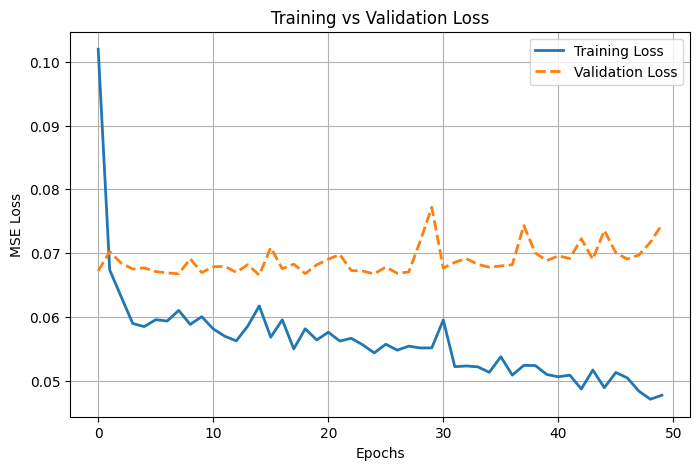

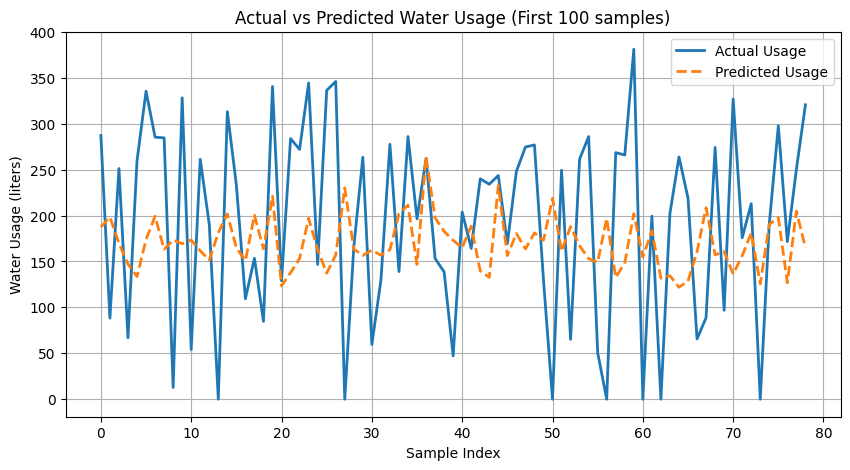

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
💧 Predicted next-day water usage: 144.43 liters


/tmp/ipython-input-188951370.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_full[0, -1] = predicted_scaled


In [12]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# Actual vs Predicted
plt.figure(figsize=(10,5))
plt.plot(y_true[:100], label='Actual Usage', linewidth=2)
plt.plot(y_pred[:100], label='Predicted Usage', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Water Usage (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Water Usage (liters)')
plt.legend()
plt.grid(True)
plt.show()

#  Predict Next Day Usage

last_7_days = scaled[-seq_length:, :-1].reshape(1, seq_length, X.shape[2])
predicted_scaled = model.predict(last_7_days)
predicted_full = np.zeros((1, scaled.shape[1]))
predicted_full[0, -1] = predicted_scaled
predicted_usage = scaler.inverse_transform(predicted_full)[0, -1]
print(f"💧 Predicted next-day water usage: {predicted_usage:.2f} liters")
